 Flow Data Analysis Pipeline for PTEN, FBXO11, and DQB1 analysis.
Based on the csv export of indexing sorting data. Each plate is labelled by experiment name and plate ID. 

# Load libraries

In [11]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(tidyverse)
    library(ggpubr)
    library(patchwork)
    source("misc_funcs.R") # extra functions
    source("utils.R") # extra utility functions
    })

# Import and process individual raw indexing flow files

In [6]:
#Import the raw flow files exported from BIGFOOT or ARIAII instrument. Each file is from a single plate. 
#In this case, the files were renamed with *_P#.csv. The # signifies the plate. 
suppressMessages({
    suppressWarnings({
    
files<- list.files(pattern = "*P[0-9].csv$") # list the files with the designated convention.
    

#Call column names and fix
fixedcolnames <- colnames(read_csv(files[1], skip =1)) # read in the first column names. 
realcolumnnames <- c("Well_ID", "Events",fixedcolnames[3:length(fixedcolnames)]) # Fix the column names
    
    })
    })

# The resultant file is still a bit amigious depending on the parameters used to collect

In [7]:
#Define experiment specific colnames. 
#This should be carefully defined based on the experiment. Check the raw data to ensure this is correct.
ExperimentSpecificColnames<- c(
"Experiment_Index", 
"Plate",
"Well_ID", 
"PB_CD45", 
"BV605_CD45",
"SSC", 
"FSC",
"FITC_DQB1",
"PE_CD40",
"PECY7_CD45", 
"APC_CD95", 
"APCCY7_CD45")

In [8]:
#Import All Files into a list object. Skipping the first three rows because they are not formatted corectly
FlowMatrix <- lapply(files, read_csv, skip = 3, col_names = realcolumnnames) 

#Add File Names loacted in the last 5 characters of the name. This may change depending on the experiment.
filesnames <- files %>% str_sub(end=-5)
names(FlowMatrix) <- filesnames

#Collapse the list into one large matrix
FlowMatrix <- bind_rows(FlowMatrix, `.id` = "Plate_ID")

#Delete unnecessary columns. Everything is doubled because of the export settings on the BigFoot. 
#This is cleaned below
toDelete<- seq(3, length(FlowMatrix), 2)
FlowMatrix <- select(FlowMatrix, -toDelete)

#Split the Plate ID into experiment and plate. In this case (PTEN, FBXO11, DQB1) & plate #.
FlowMatrix <- FlowMatrix %>% separate(Plate_ID, into = c("Experiment", "Plate"), sep = "_")

#FixColumn Names with the ones you carefully defined above
colnames(FlowMatrix) <- ExperimentSpecificColnames

Rows: 384 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Well_ID
dbl (19): Events, 405nm - Pacific Blue...3, 405nm - Pacific Blue...4, 405nm ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Well_ID
dbl (19): Events, 405nm - Pacific Blue...3, 405nm - Pacific Blue...4, 405nm ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Well_ID
dbl (19): Events, 405nm - Pacific Blue...3, 405nm - Pacific Blue...4, 405nm ...

ℹ Use `spec()` to retrieve the full colum

In [9]:
# A quick look at this file. 
head(FlowMatrix)

Experiment_Index,Plate,Well_ID,PB_CD45,BV605_CD45,SSC,FSC,FITC_DQB1,PE_CD40,PECY7_CD45,APC_CD95,APCCY7_CD45
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DQB1,P1,A1,21.28752,295.5991,6731.704,29032.91,107.4608,180.243402,1.000000,45.725267,15.891756
DQB1,P1,A2,105.07137,995.5129,40679.443,38025.78,2236.7084,6.042964,8.856571,795.043013,68.538958
DQB1,P1,A3,78.43886,634.9425,26535.552,43518.30,1333.5214,10.366329,15.538398,1165.215492,131.565077
DQB1,P1,A4,831.61416,433.2302,12921.952,25368.62,161.0762,43.714448,1.000000,9.690097,7.914755
DQB1,P1,A5,102.73508,518.6134,19809.568,34754.87,1492.2037,3.292897,22.773085,2186.974655,4.123200
DQB1,P1,A6,102.73508,197.2068,14459.599,39774.93,443.0823,1.000000,1.567879,120.248073,53.519941


# Analysis and defining of populations

We used antibody staining to hash conditions and define cell types. This is a great positive control and enables internal control on every plate. 

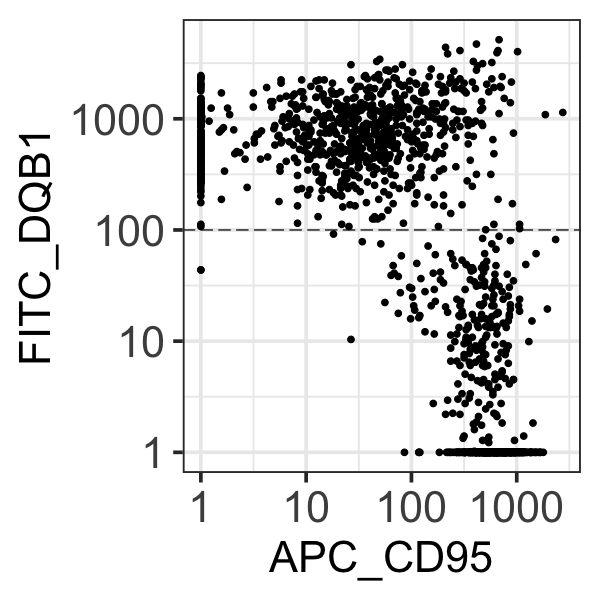

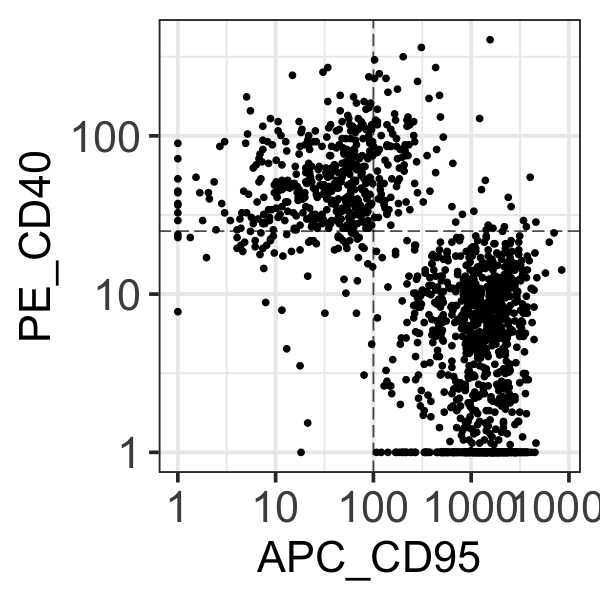

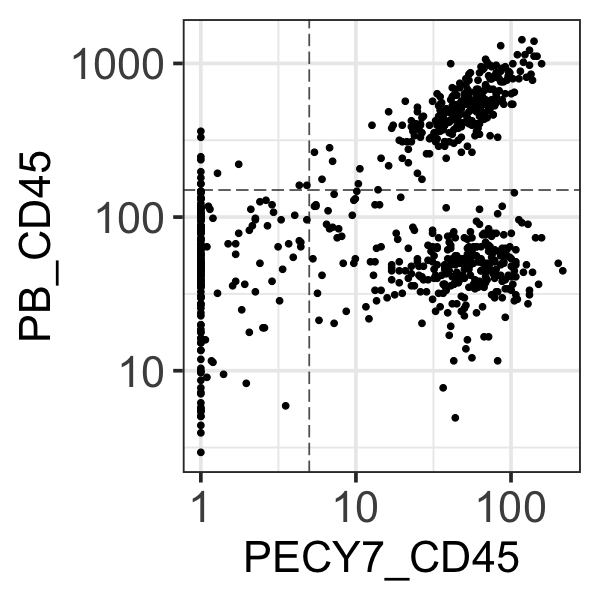

In [34]:
# A quick look at the data let's us know where to set cutoffs for defining cell in each experiment.
#FBXO11 data. 
fig.size(5,5) # set figure size
(FlowMatrix %>% na.omit() %>% dplyr::filter(Experiment_Index == "FBXO11") %>%  
    ggplot(aes(APC_CD95, FITC_DQB1)) + geom_point()  + 
    scale_x_log10() + scale_y_log10() + geom_hline(yintercept=100, linetype = "longdash", alpha = 0.7)
) + theme_gy()

#DBQ1 data
(FlowMatrix %>% na.omit() %>% dplyr::filter(Experiment_Index == "DQB1") %>%  
    ggplot(aes(APC_CD95, PE_CD40)) + geom_point()  + 
    scale_x_log10() + scale_y_log10()  + geom_hline(yintercept = 25, linetype = "longdash", alpha = 0.7) + 
    geom_vline(xintercept = 100, linetype = "longdash", alpha = 0.7)
)+ theme_gy()

#PTEN data
(FlowMatrix %>% na.omit() %>% dplyr::filter(Experiment_Index == "PTEN") %>%  
    ggplot(aes(PECY7_CD45, PB_CD45)) + geom_point()  + 
    scale_x_log10() + scale_y_log10() + geom_hline(yintercept = 150, linetype = "longdash", alpha = 0.7) + 
    geom_vline(xintercept = 5, linetype = "longdash", alpha = 0.7)
 )+ theme_gy()

In [36]:
#We are going to define B cells in the FBXO11 experiment with DQB1 expression. 
#HLA II should only be found on Daudis. Values greater than 100 are Daudis, the rest of the cells are Jurkats.
FlowMatrix <- mutate(FlowMatrix, "FBXO11_CellType_Index" = ifelse(FITC_DQB1 > 100, "Daudi", "Jurkat"))

#Define HH and Daudis for DQB1 Experiment based on CD95 and CD40 Expression (only on T cells)
FlowMatrix <- FlowMatrix %>% 
    dplyr::mutate("DQB1_CellType_Index" = ifelse(PE_CD40 < 25 & APC_CD95 > 100, "HH", "Daudi"))

#Define Edited cells based on PB_CD45 expression for FBXO11-DQB1 experiments. 
FlowMatrix <- mutate(FlowMatrix, "Edited_Index" = ifelse(PB_CD45 > 250, "Control", "Edited"))

#For the PTEN experiment PB_CD45 marks Daudis. ### Define Daudis, Jurkats, and HEK293T cells for PTEN experiment
FlowMatrix <- FlowMatrix %>% 
    mutate("PTEN_CellType_Index" = ifelse(PECY7_CD45 > 5, ifelse(PB_CD45>150, "Daudi", "Jurkat"), "HEK293T"))

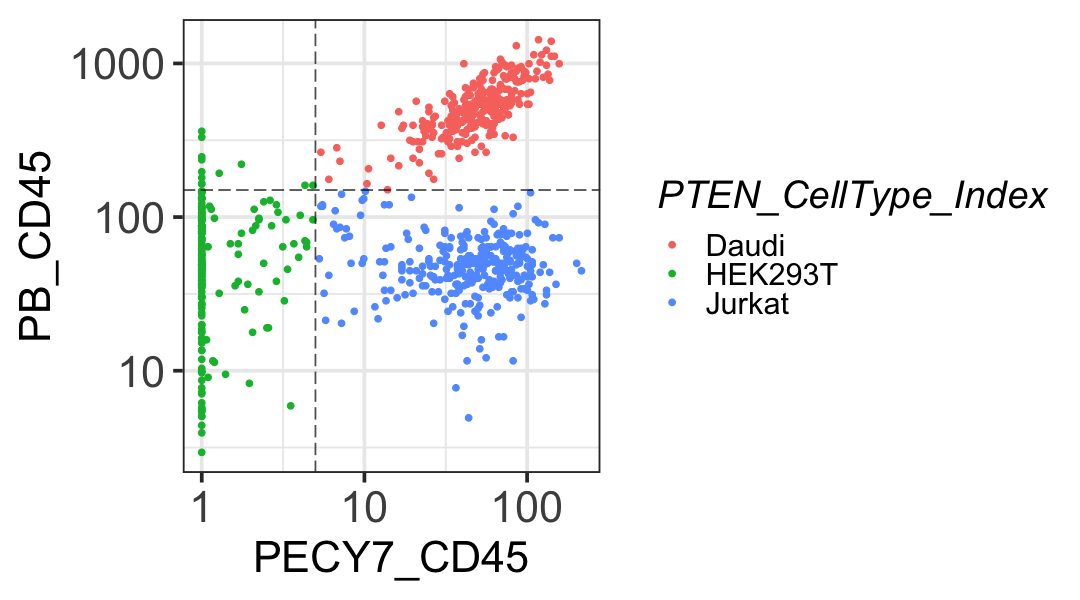

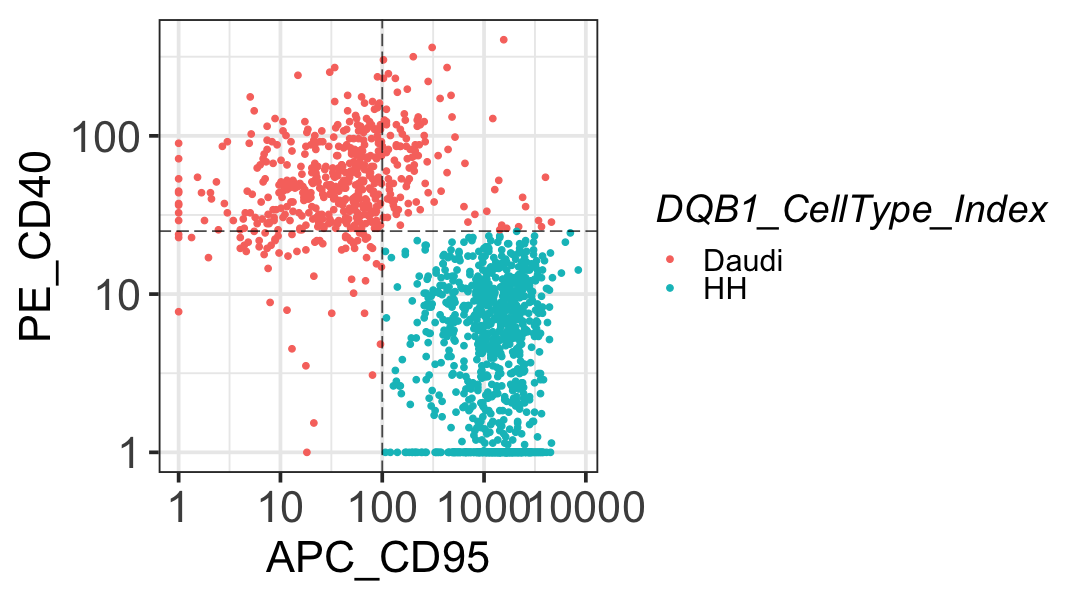

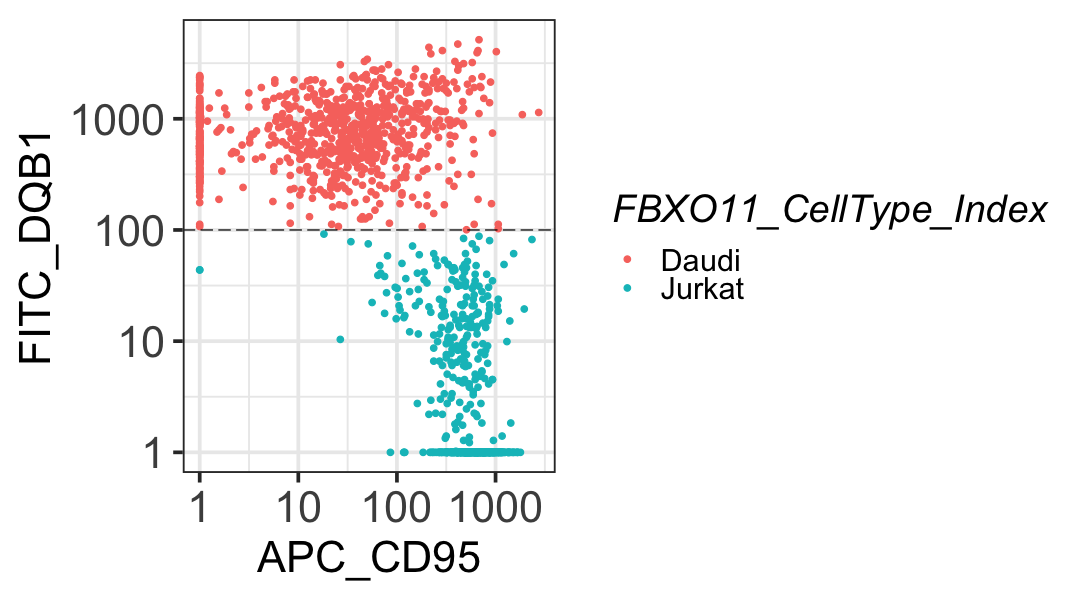

In [37]:
##### Check Distribution with cell types
fig.size(5,9) # set new fig dimensions because of the labelling. 
(FlowMatrix %>% na.omit() %>% dplyr::filter(Experiment_Index == "PTEN") %>%  
    ggplot(aes(PECY7_CD45, PB_CD45, color = PTEN_CellType_Index)) + geom_point() + 
    scale_x_log10() + scale_y_log10() + geom_hline(yintercept = 150, linetype = "longdash", alpha = 0.7) + 
    geom_vline(xintercept = 5, linetype = "longdash", alpha = 0.7)
 )+ theme_gy()

(FlowMatrix %>% na.omit() %>% dplyr::filter(Experiment_Index == "DQB1") %>%  
    ggplot(aes(APC_CD95, PE_CD40, color = DQB1_CellType_Index)) + geom_point()  + 
    scale_x_log10() + scale_y_log10()  + geom_hline(yintercept = 25, linetype = "longdash", alpha = 0.7) + 
    geom_vline(xintercept = 100, linetype = "longdash", alpha = 0.7)
)+ theme_gy()

(FlowMatrix %>% na.omit() %>% dplyr::filter(Experiment_Index == "FBXO11") %>%  
    ggplot(aes(APC_CD95, FITC_DQB1, color = FBXO11_CellType_Index)) + geom_point()  + 
    scale_x_log10() + scale_y_log10() + geom_hline(yintercept=100, linetype = "longdash", alpha = 0.7)
) + theme_gy()

# Add DNA and RNA barcodes based on well position to facilitate future analysis

In [38]:
# Merge DNA and RNA barcode labels onto the master flow file to then re-export this for later
FlowMatrixFinal <- inner_join(read_csv("DNABarcodes.csv"), read_csv("RNABarcodes.csv")) %>% inner_join(FlowMatrix)

Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, DNA_Barcode

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_Barcode

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(Well_ID)`


In [39]:
#Export the Analysis for Posterity
FlowMatrixFinal %>% write_csv("FlowMatrixFinal.csv")